# Replicating stable diffusion training on MNIST dataset

I've been fascinated by the advancements of the diffusion models in the past few years. LLMs and diffusion models have become the basis of all the generative AI advancements since GPT-2 and latent diffusion came out.

Training a model from scratch in case of both LLMs and diffusion models is not a practical solution for most enterprises. Instead, its a safer and more cost efficient bet to finetune an existing pretrained model. Stable diffusion 1.5 is one of the most popular diffusion model that gave promising results in the image generation space. Several new techniques such as controlnets, lora finetuning, image-to-image, diffusion upscaling, etc sprung after the introduction of the open-source stable diffusion.

I'll try to replicate the overall stable diffusion architecture in this post.

The architecture is based on a few different techinques. At its core it uses the DDPM diffusion process to generate image out of the noise. The U-net model is used to predict noise at a certain timestep, which is used to denoise a noisy image in the inference process.

In [3]:
## installing basic libraries from diffusers and transformers.
%pip install -q diffusers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00


## What we're doing here.

If we're just trying to train a diffusion model that generates images without any text prompts randomly, then we don't need a clip text encoder or anything like that. But we need the model to generate image based on text prompts so we can train a text encoder like CLIP which is used to generate a text embedding which is then used in training the Unet.

We can either train the CLIP model from scratch or use a pretrained one. When finetuning you have the option to train the text encoder. In our case, the Unet is trained from sratch, so to reduce the complexity I opted to use a pretrained CLIP model. However, it didn't work so I also adjusted the CLIP models weights i.e finetuned it.

- This architecture doesn't use a VAE to reduce 512px images to 64x64 latents, cause the MNIST dataset already is 28x28 pixels.
- We finetuned the CLIP model to get better results.
- We also use classifier free guidance.
- We adjust the blockout channels values when initializing the Unet Model.
- cross_attention_dim=512, this should match the dim of CLIP model, check the pretrained model specs for the right value.

## Training

Notes:
We also finetune the text_encoder. other wise it doesn't work.

- Text encoder also trained / finetuned.
- uses grayscale images, 1 channel only for MNIST.
- quick to train.
- No VAE used. already 28x28 pixel size so no need.
- classifier free guidance inference also possible.

## Step 1 : Loading Data

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Load MNIST dataset and resize to 64x64
transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Now that we have the dataset, lets load it into a dataloader of batch size 4 and see the first batch.

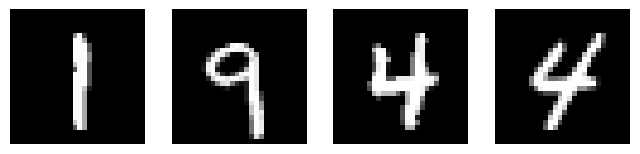

In [8]:
import matplotlib.pyplot as plt
import numpy as np
preview_dataloader = DataLoader(mnist_dataset, batch_size=4, shuffle=True)
# Get the first batch of images
batch = next(iter(preview_dataloader))
# Extract the images from the batch
images = batch[0]

# Plot the images as a grid
plt.figure(figsize=(8, 8))
for i, img in enumerate(images):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Step 2 : Define U-net model

I've used the `UNet2DConditionModel` from diffusers library to init a Unet model that also takes text emebeddings. the sample_size is the input size for the unet model which is 28 cause MNIST size is 1x28x28. in_channels and out_channels are 4 in original stable diffusion because the VAE output is fed into the Unet, 4x64x64. but MNIST is grayscale so only 1 channel. if we were feeding a rgb dataset like CIFAR then it would be 3x28x28. the block channels are also 32,64,64,32 and layers per block is 2. so there are fewer blocks and fewer layers per block.

All this is done to reduce the parameter count and train the model faster for faster feedback and learning. TODO: share the original unet paremeters for stable diffusion.

In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom UNet2DConditionModel with reduced parameters
class CustomUNet2DConditionModel(UNet2DConditionModel):
    def __init__(self, **kwargs):
        super().__init__(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # Reduced from default
            block_out_channels=(32, 64, 64, 32),  # Reduced from default
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
            cross_attention_dim=512,  # CLIP embedding dimension
            **kwargs
        )

# Load models
unet = CustomUNet2DConditionModel().to(device)

## Step 3 : Loading a pretrained CLIP model
As I said before, you can train this model from sratch as well, but I'm gonna use this pretrained CLIP model from openai along with the tokenizer.
I've also set the requires_grad_ to True to change the model weights during training. I tried without finetuning the text encoder but it didn't work.

One handy change I made for the CLIP model was reduce the TOKENIZER_MAX_LENGTH to 8 from 77 default. this change means that the text embedding size from the text_encoder was smaller from 77x512 to just 8x512.

In [9]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(True)

NameError: name 'CLIPTextModel' is not defined

In [ ]:
tokenizer.model_max_length

In [ ]:
TOKENIZER_MAX_LENGTH = 8
captions_sample = ['"A handwritten digit 1']
text_input = tokenizer(captions_sample, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape
## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 8, 512])

## Step 4 : Scheduler and Training

Now we define the noise_scheduler and the train_dataloader with a batch_size (bs) of 512. A bs greater than 512 didn't fit in the T4 gpu in colab. I'm also use a rather high 1e-3 learning rate to train faster and iterate quickly.

A few improvements in the following code is that I could have generated captions from the MNIST labels and turned them into text embeddings separately. This would mean that during training we won't have to turn the captions to embeddings for each epoch. In case of larger training runs, if I don't have to use CLIP model to turn captions to embeddings during training, I don't have to put the CLIP model and Unet model in GPU VRAM at once. Since our models are small they're not an issue, but in case of larger models this kind of optimization is necessary.

In [ ]:
from diffusers import DDPMScheduler, DDPMPipeline
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [ ]:
train_dataloader = DataLoader(mnist_dataset, batch_size=512, shuffle=True)
next(iter(train_dataloader))[0].shape

torch.Size([512, 1, 28, 28])

In [ ]:
train_dataloader = DataLoader(mnist_dataset, batch_size=512, shuffle=True)

# Training parameters
# num_epochs = 100
num_epochs = 1
# learning_rate = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images = images.to(device)

        # Create text captions from labels
        captions = [f"A handwritten digit {label}" for label in labels]

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/1, Loss: 0.06978640705347061


I'm also using two different notebook cells. the first to do a test one epoch run, and the next to continue the training and see the loss.

In [ ]:
num_epochs=5
steps= 0
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images = images.to(device)

        # Create text captions from labels
        captions = [f"A handwritten digit {label}" for label in labels]

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        steps = steps+1
        if (steps%25==0):
          print(f"steps {steps}, Loss: {loss.item()}")
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/5:   0%|          | 0/118 [00:00<?, ?it/s]

steps 25, Loss: 0.061696138232946396
steps 50, Loss: 0.060181986540555954
steps 75, Loss: 0.057418376207351685
steps 100, Loss: 0.054266683757305145
Epoch 1/5, Loss: 0.05767202004790306


Epoch 2/5:   0%|          | 0/118 [00:00<?, ?it/s]

steps 125, Loss: 0.05253804847598076
steps 150, Loss: 0.05339432135224342
steps 175, Loss: 0.05236339569091797
steps 200, Loss: 0.048620302230119705
steps 225, Loss: 0.051217738538980484
Epoch 2/5, Loss: 0.04950748383998871


Epoch 3/5:   0%|          | 0/118 [00:00<?, ?it/s]

steps 250, Loss: 0.05148658528923988
steps 275, Loss: 0.05175504833459854
steps 300, Loss: 0.04731001704931259
steps 325, Loss: 0.0488668829202652
steps 350, Loss: 0.04429564252495766
Epoch 3/5, Loss: 0.049831707030534744


Epoch 4/5:   0%|          | 0/118 [00:00<?, ?it/s]

steps 375, Loss: 0.04424316808581352
steps 400, Loss: 0.04646334424614906
steps 425, Loss: 0.041940152645111084
steps 450, Loss: 0.0474511943757534
Epoch 4/5, Loss: 0.05243955925107002


Epoch 5/5:   0%|          | 0/118 [00:00<?, ?it/s]

steps 475, Loss: 0.04557150974869728
steps 500, Loss: 0.04647282883524895
steps 525, Loss: 0.04580245912075043
steps 550, Loss: 0.04568237438797951
steps 575, Loss: 0.044844504445791245
Epoch 5/5, Loss: 0.0512877032160759


In [ ]:
!ls

data  generated_digit.png  text_encoder_clip.pth  unet.pth


# Inference of our model

Now we're going to use the trained model to generate images based on text prompts.

The first inference sampling code doesn't use classifier free guidance. In classifier free guidance, we use results from an empty prompt and the text prompt to get the image.

<ipython-input-139-4a71155ce52a>:19: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


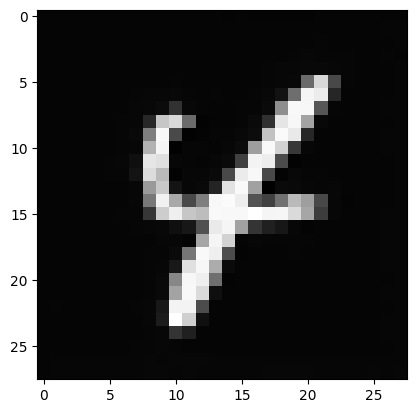

In [ ]:
from diffusers import DDPMScheduler, DDPMPipeline
# Set models to evaluation mode
vae.eval()
text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    torch.manual_seed(422)  # Set the seed
    latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


In [ ]:
## save unet and text_encoder
# Save the trained model
torch.save(unet.state_dict(), "./unet.pth")
torch.save(text_encoder.state_dict(), "./text_encoder_clip.pth")

## inference classifier free guidance

<ipython-input-149-526512d53a86>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


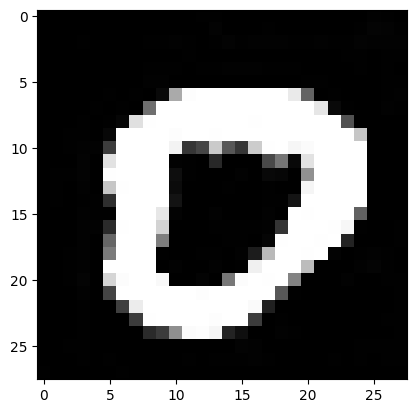

In [ ]:
## classifier free guidance
from diffusers import DDPMScheduler, DDPMPipeline
# Set models to evaluation mode
vae.eval()
text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
guidance_scale = 8

@torch.no_grad()
def generate_image(prompt, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 0"
generated_images = generate_image(prompt)

# Display or save the image
image = generated_images[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


## Testing different guidance scales

<ipython-input-149-526512d53a86>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])


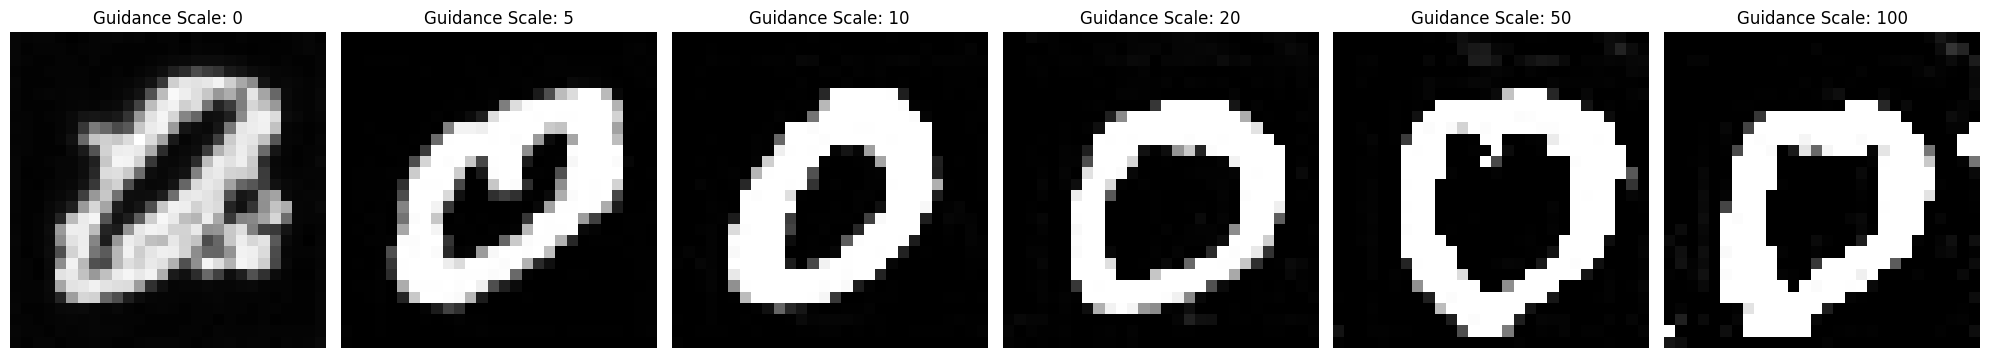

In [ ]:
import matplotlib.pyplot as plt

# Define the guidance scale values
guidance_scales = [0, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Set the guidance scale
    # global guidance_scale
    # guidance_scale = guidance_scale

    # Generate an image
    prompt = "A handwritten digit 0"
    generated_image = generate_image(prompt)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'Guidance Scale: {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

# What now?
This is a very simple attempt at replicating the stable diffusion arch. I still haven't mastered the aspects of noise schedulers, classifier free guidance, etc.

Others or me in the future can expand on this post by training a diffusion model on CIFAR dataste or imagenet dataset. ofcourse the unet params used might not be enough and should be scaled as per the complexity of the dataset.

Common best practices like turning captions to text embeddings before training can be implemented for efficiency, but those changes are omitted from this post for the sake of simplicity and comprehension.


# Resources
**Primary resources**
- class conditioned diffusion model HF tut, MNIST - https://huggingface.co/learn/diffusion-course/en/unit2/3 - part of a diffusion course.
- Finetuning and Guidance HF - https://huggingface.co/learn/diffusion-course/en/unit2/2#guidance
- https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py - handy for reference
- https://wandb.ai/capecape/train_sd/reports/How-To-Train-a-Conditional-Diffusion-Model-From-Scratch--VmlldzoyNzIzNTQ1#initial-checkup:-cifar-10
- MOST SIMILAR TO my implementation
	- [MNIST-Diffusion](https://colab.research.google.com/github/st-howard/blog-notebooks/blob/main/MNIST-Diffusion/Diffusion%20Digits%20-%20Generating%20MNIST%20Digits%20from%20noise%20with%20HuggingFace%20Diffusers.ipynb#scrollTo=50233a13)

**Secondary Resources**
- dump and cifar training repo - https://github.com/tcapelle/Diffusion-Models-pytorch?organization=tcapelle&organization=tcapelle

- https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/StableDiffusion
- https://github.com/cloneofsimo - clonesofsimo has a few handy repos as refernces

- zero to hero diffusion - repo of different model architecture and training code. https://github.com/swookey-thinky/mindiffusion/tree/main?tab=readme-ov-file
- this reddit post comment by OnlyJoe3 is quite insightful. For architecture and training speed and costs. https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/
- asked Claude about the learning rate scaling.
```
Learning Rate Scaling:

Original batch size: 2096
Original learning rate: 1e-4
If we reduce batch size to 32:
Scaling factor: 32 / 2096 ≈ 0.0153
Scaled learning rate: 1e-4 * 0.0153 ≈ 1.53e-6

```

- data bricks blog on diffusion training - https://www.databricks.com/blog/stable-diffusion-2
- https://www.databricks.com/blog/stable-diffusion-2
- https://johnowhitaker.github.io/tglcourse/dm3.html
- fastai stable diffusion course notebooks - https://forums.fast.ai/t/practical-deep-learning-for-coders-part-2-github-repo/110774

- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://scholar.harvard.edu/binxuw/classes/machine-learning-scratch/materials/stable-diffusion-scratch
- https://klaviyo.tech/trying-to-understand-stable-diffusion-ea55eefca798
- https://github.com/lucidrains/DALLE-pytorch
- https://github.com/OutofAi/StableFace?tab=readme-ov-file